<a href="https://colab.research.google.com/github/lsaif/RockTypePropagation/blob/master/Rocktype_Propagation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Rocktype Propagation**

####**Github repo setup**

In [0]:
from os.path import join  
from google.colab import drive

ROOT="/content/drive"
drive.mount(ROOT)

MY_GOOGLE_DRIVE_PATH = 'My Drive/' 
GIT_USERNAME = "lsaif" 
GIT_TOKEN = "3508092900c8ef7a64b1a8bf0205a601356b340a"  
GIT_REPOSITORY = "RockTypePropagation" 

PROJECT_PATH = join(ROOT, MY_GOOGLE_DRIVE_PATH)

GIT_PATH = "https://" + GIT_TOKEN + "@github.com/" + GIT_USERNAME + "/" + GIT_REPOSITORY + ".git"
%cd "{PROJECT_PATH}" 
!git clone "{GIT_PATH}" 

In [0]:
!git branch

####**Installer**

In [0]:
!pip install -q git+https://github.com/tensorflow/docs

####**Authenticate to access Google Drive**

In [0]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

####**Import supporting libraries**

In [0]:
import sys
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from os import listdir
from sklearn import model_selection
from sklearn.model_selection import KFold
from sklearn import linear_model
from sklearn.preprocessing import StandardScaler, label_binarize
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import RandomForestClassifier
import torch
from torch import nn
from torch import optim
from torch.utils.data import TensorDataset, DataLoader
from torchvision import transforms
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from keras.optimizers import SGD, adam
import tensorflow as tf
import tensorflow_docs as tfdocs
import tensorflow_docs.plots
import tensorflow_docs.modeling
import timeit

np.set_printoptions(threshold=sys.maxsize)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)

tf.keras.backend.clear_session()

print("Eager mode: ", tf.executing_eagerly())
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))
print('Cuda:',torch.cuda.is_available())
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

Eager mode:  True
Found GPU at: /device:GPU:0
Cuda: True


####**Data Loading**

In [0]:
def LoadData(url,filename):
  fluff, id = url.split('=')
  downloaded = drive.CreateFile({'id':id}) 
  downloaded.GetContentFile(filename)
  return filename

LoadData(url="https://drive.google.com/open?id=1JAc9PfGK0b4IrtRkv7m5o2yhD8P_bb9t", filename="hfu_data.csv")
dset = pd.read_csv("hfu_data.csv", sep=';').set_index('Well')
print(dset.head(5))
dset = dset.dropna()
#sns.pairplot(dset[["GR", "NPHI", "RHOB", "ILD", "PHIE", "SWE", "HFU"]], diag_kind="kde")

             Depth     Por   Perm  Fasies_enc  Fasies  HFU        GR  \
Well                                                                   
JTB-047  2425.2936  0.0436  0.020           2  LITHIC    9  159.8818   
JTB-047  2425.5984  0.0557  0.080           2  LITHIC   10  145.3258   
JTB-048  2001.5456  0.1649  0.140           2  LITHIC    7  193.9869   
JTB-048  2001.6980  0.1649  0.140           2  LITHIC    7  193.9899   
JTB-051  2196.6374  0.0486  2.883           3    LAVA   14   85.0744   

             NPHI      RHOB     ILD     PROX      PHIE       SWE  
Well                                                              
JTB-047  0.169437  2452.768  6.8167  19.4682  0.134611  0.966523  
JTB-047  0.173898  2423.823  6.7381  21.6627  0.145651  0.899416  
JTB-048  0.265260  2367.800  4.0185  12.8280  0.195563  0.837456  
JTB-048  0.256040  2371.300  4.0252   7.2460  0.199310  0.823007  
JTB-051  0.156100  2483.100  4.4219   3.4980  0.115553  1.000000  


In [0]:
dset.describe()

####**Pre-processing**

In [0]:
db = dset[['GR','ILD','PROX','HFU']].copy()
X = db.iloc[:,0:3].values
Y = db.iloc[:,-1].values
Y = label_binarize(Y, classes=[0,1,2,3,4,5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16])
test = 0.20
seed = 0
X_train, X_test, Y_train, Y_test = model_selection.train_test_split(X, Y, test_size=test, random_state=seed)

#scaler = StandardScaler()
#X_train = scaler.fit_transform(X_train)
#X_test = scaler.transform(X_test)
print (Y_test)

[[0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0]
 [0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0]
 [0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0]]


####**Model**

In [0]:
def ModelAnn():
  classifier = Sequential([
                           Dense(3, activation = 'relu', input_dim=3),
                           #Dense(35,activation = 'relu'),
                           Dense(17, activation='softmax'),
                           #Dropout(0.2)                     
        ])
  lr = 0.1
  decay = 0.0001
  momentum = 0.75
  sgd= SGD(lr=lr, momentum=momentum, decay=decay,nesterov=False)
  adm = adam(lr=lr,decay=decay)
  classifier.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy','mae','msle'])
  return classifier

def ModelLinear():
  classifier = linear_model.SGDClassifier(loss='huber', penalty='elasticnet', verbose=1)
  return classifier
  
def ModelRF():
        classifier = RandomForestClassifier(n_estimators=100, random_state=seed, n_jobs=-1, verbose=1)
        return classifier

####**Train, test, predict**

In [0]:
#classifier = KerasClassifier(build_fn=ModelAnn, epochs=300, batch_size=5, verbose=1)
classifier = ModelAnn()
#with tf.device('/cpu:0'):
def fitmodel():
  with tf.device('/device:GPU:0'):
    history = classifier.fit(X_train, Y_train, validation_split=0.2, epochs=300, batch_size=5, verbose=1)
    Y_predict = classifier.predict(X_test)
    return history, Y_predict

history, Y_predict = fitmodel()

print('GPU (s):')
#cpu_time = timeit.timeit('fitmodel()', number=1, setup="from __main__ import fitmodel")
#print(cpu_time)

In [0]:
print(Y_predict.argmax(1))
print(Y_test.argmax(1))

[ 7  5  7  7  6  7 10 13  7 10  7  8  8]
[ 5  6  7  8  8  6  7 12  7  8  5 14  8]


####Train, test, predict - Torch

In [0]:
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5,), (0.5,))])

X_train = torch.from_numpy(X_train).float().to(device)
Y_train = torch.from_numpy(Y_train).to(device)
X_test = torch.from_numpy(X_test).float().to(device)
Y_test = torch.from_numpy(Y_test).to(device)

trainset = TensorDataset(X_train, Y_train)
trainloader = DataLoader(trainset, batch_size=64, shuffle=True)

testset = TensorDataset(X_test, Y_test)
testloader = DataLoader(testset, batch_size=64, shuffle=True)

In [0]:
model = nn.Sequential(nn.Linear(3, 128),
                      nn.ReLU(),
                      nn.Linear(128, 17),
                      nn.LogSoftmax(dim=1))

model.cuda()
Xtrain, Ytrain = next(iter(trainloader))

criterion = nn.NLLLoss()
optimizer = optim.SGD(model.parameters(),lr= 0.01)
epoch = 20
loss_ = []
loss_test = []
for i in range(epoch):
    running_loss = 0
    for Xtrain, Ytrain in trainloader:
        optimizer.zero_grad()
        output = model(Xtrain)
        loss = criterion(output,Ytrain)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    else:
        #print(f"Training loss: {running_loss/len(trainloader)}")
        with torch.no_grad():
          logps = model(X_test)
        predict = torch.exp(logps)
        loss_test.append(criterion(predict,Y_test).cpu().numpy())
        loss_.append(running_loss/len(trainloader))

In [0]:
with torch.no_grad():
    logps = model(X_test)
predict = torch.exp(logps)
loss_test = criterion(predict,Y_test).cpu().numpy()
print(loss_test,' ',predict)

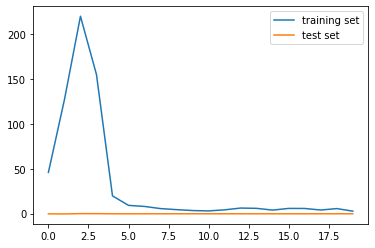

In [0]:
plt.plot(range(epoch),loss_,label="training set")
plt.plot(range(epoch),loss_test,label="test set")
plt.legend()

####**Check**

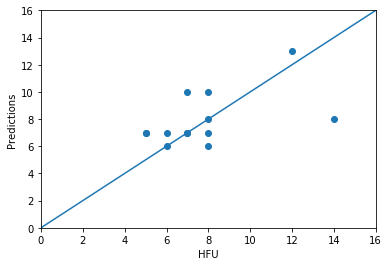

In [0]:
plt.scatter(Y_test.argmax(1), Y_predict.argmax(1))
plt.xlabel('HFU')
plt.ylabel('Predictions')
lims = [0, 16]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)

from sklearn.metrics import confusion_matrix, accuracy_score
#cm = confusion_matrix(Y_test, Y_predict)
acc = accuracy_score(Y_test.argmax(1), Y_predict.argmax(1))
#print(cm)
#print(acc)

####**History**

Text(0, 0.5, 'Loss')

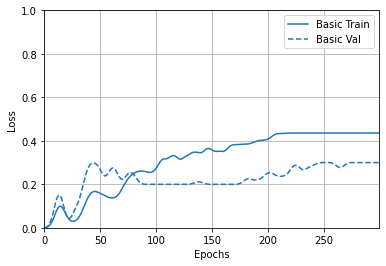

In [0]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail(5)
plotter = tfdocs.plots.HistoryPlotter(smoothing_std=2)
plotter.plot({'Basic': history}, metric = 'accuracy')
plt.ylim([0, 1])
plt.ylabel('Loss')

####**Propagation**

In [0]:
LoadData(url="https://drive.google.com/open?id=101yfKa9jPW3umaUpi9SXzgvQqzQA4Zf5", filename="wire_jtb_hfu.csv")
wire = pd.read_csv("wire_jtb_hfu.csv", sep=';').set_index('WELL')
LoadData(url="https://drive.google.com/open?id=1WHGb8A7J53eDeJtrGY59VNoR5i3JgoKL", filename="efac.csv")
efac = pd.read_csv("efac.csv", sep=';').set_index('WELL')

data = wire.merge(efac, how='right', left_on=['WELL','DEPTH'], right_on=['WELL','DEPTH'])
data = data.dropna()
print(data.head(5))

In [0]:
X_data = data.iloc[:,[1,2,4,6]]
Y_data = classifier.predict(X_data).argmax(1)
print(X_data.head(5))
prediction = data
prediction['HFU_PRED'] = Y_data
prediction.to_csv('HFU_pred.csv', sep=',')
from google.colab import drive
drive.mount('drive')
!cp HFU_pred.csv "drive/My Drive/Colab Notebooks"

####**Commit to Github**

In [0]:
%cd "{PROJECT_PATH}"
%cd "{GIT_REPOSITORY}" 
!git add .
!git commit -m "add from Google Colab"
!git config --global user.email "luthfi@geodin.net"
!git config --global user.name "lsaif"
!git push -u origin master